# Project: Identify Customer Segments

In this project, I applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I used has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I used this information to cluster the general population into groups with similar demographic properties. There are certain clusters where people are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Loading in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Loading in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Checking the structure of the data after it's loaded (e.g. printing the number of
# rows and columns, printing the first few rows).
print("The shape of azdias is: {}. \nThe shape of feat_info is: {}".format(azdias.shape,feat_info.shape))

The shape of azdias is: (891221, 85). 
The shape of feat_info is: (85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_BAUMAX,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
#finding nulls in azdias
azdias_null = azdias.isnull().sum()
total_missing = azdias_null.sum()
print("Total missing values in the demographics data for the general population of Germany are: {}".format(total_missing))

Total missing values in the demographics data for the general population of Germany are: 4896838


In [11]:
#finding nulls in feat_info
feat_info_null = feat_info.isnull().sum()
total_feat_info_null = feat_info_null.sum()
print("Total missing values in the summary of feature attributes for demographics data are: {}"
      .format(total_feat_info_null))

Total missing values in the summary of feature attributes for demographics data are: 0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. Converting data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [12]:
# Identifying missing or unknown data values and convert them to NaNs.
    
def missing_or_unknown(general_population):
    for index, value in enumerate(general_population.iteritems()):
        unknown_data = feat_info['missing_or_unknown'][index]
        columns = value[0]
        unknown_data = unknown_data[1:-1].split(',')
        if unknown_data != ['']:
            new_var = []
            for x in unknown_data:
                if x in ['X','XX']:
                    new_var.append(x)
                else:
                    new_var.append(int(x))
            general_population[columns] = general_population[columns].replace(new_var, np.nan)
            
    return general_population

In [13]:
azdias = missing_or_unknown(azdias)

In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

In [15]:
# Performing an assessment of how much missing data there is in each column of the dataset.
total_null = azdias.isnull().sum()

In [16]:
print("Total number of missing values in original dataset is: {}".format(total_null.sum()))

Total number of missing values in original dataset is: 8373929


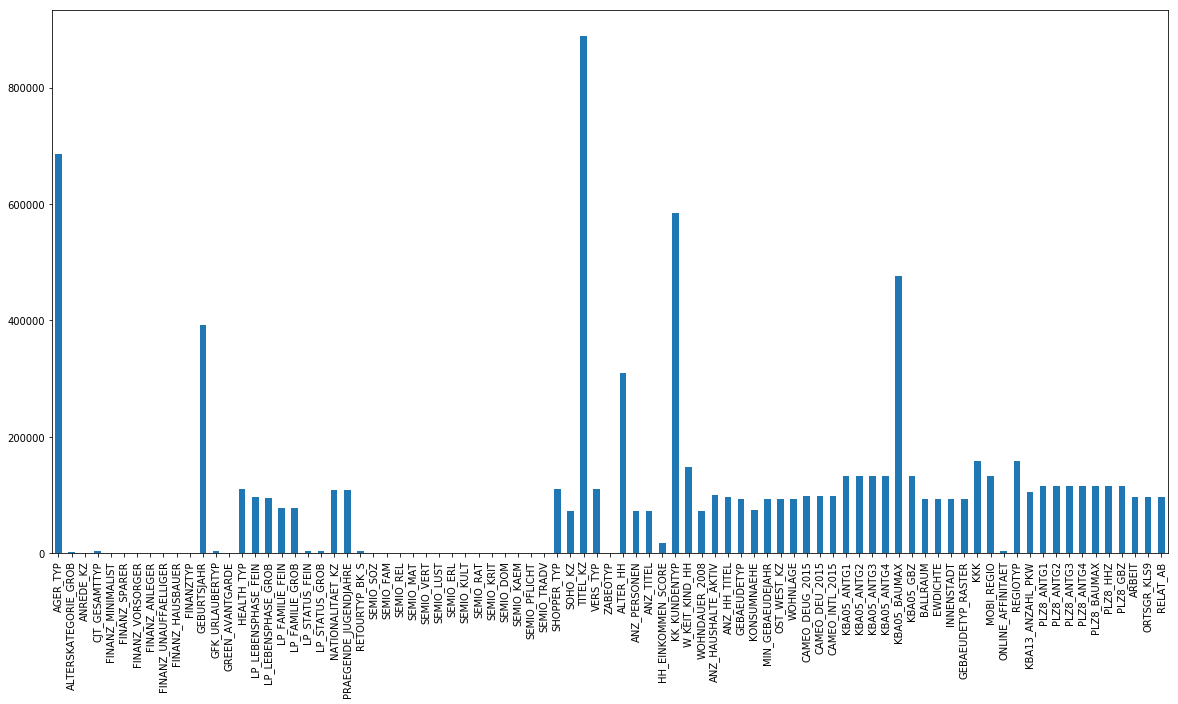

In [17]:
# Investigating the patterns in the amount of missing data in each column.
total_null.plot.bar(figsize=(20,10));

In [18]:
#Finding proportions of missing values in each column
null_proportion = total_null/azdias.shape[0] * 100

#Sorting the proportion of nulls in every column in descending order
null_proportion.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

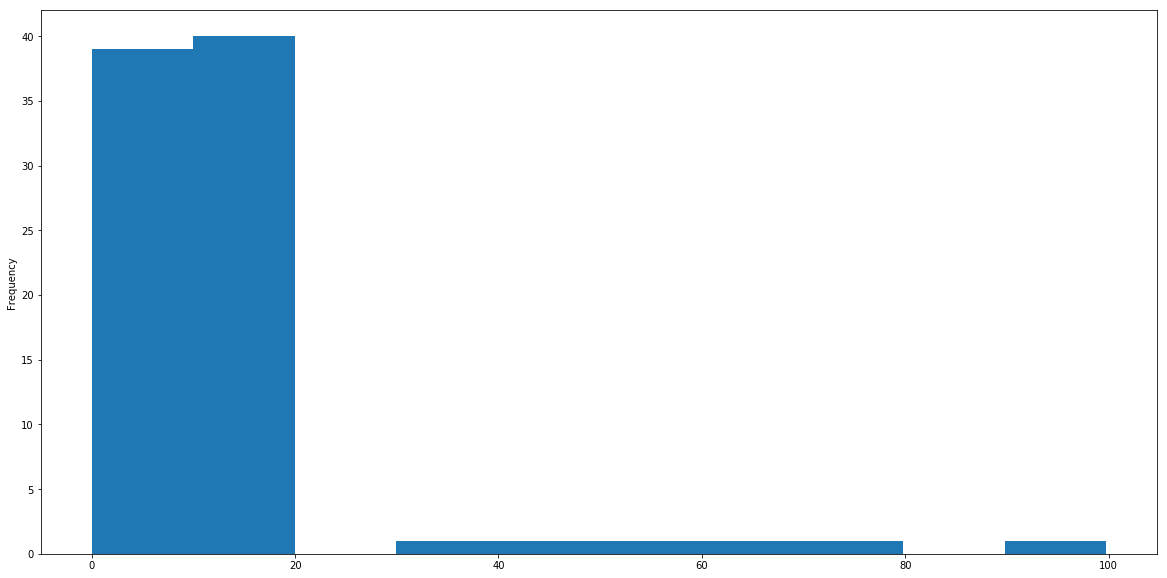

In [19]:
null_proportion.plot.hist(figsize=(20,10))

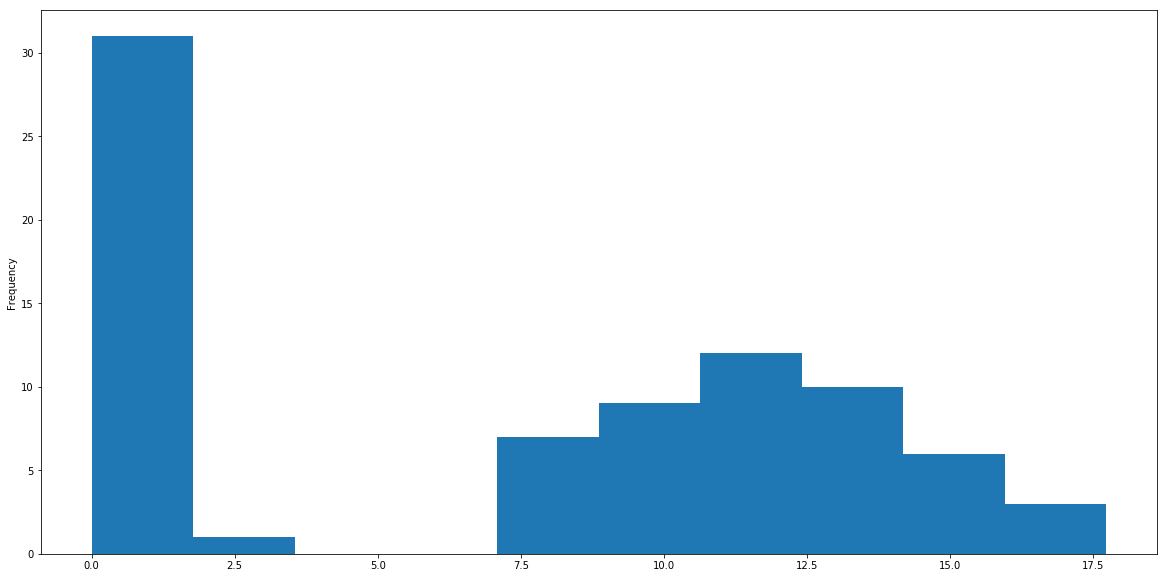

In [20]:
#Exploring the proportion between 0 to 20
null_below_20 = null_proportion[null_proportion<20]

null_below_20.plot.hist(figsize=(20,10))

In [21]:
#removing columns whose null proportion is more than 20%
azdias = azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'],axis=1)
azdias.head()                      

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
azdias.isnull().sum().value_counts()

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
77792      2
97375      2
158064     2
97632      1
93155      1
94572      1
105800     1
2881       1
18348      1
97008      1
108315     1
73969      1
99611      1
147988     1
108164     1
97274      1
dtype: int64

In [23]:
null_count = azdias.isnull().sum().sort_values(ascending=False)
null_count

KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DEUG_2015           99352
LP_LEBENSPHASE_FEIN       97632
RELAT_AB                  97375
ARBEIT                    97375
ORTSGR_KLS9               97274
                          ...  
GFK_URLA

In [24]:
null_count.sum()

5035304

#### Discussion 1.1.2: Assess Missing Data in Each Column

I decided to drop 6 columns which had missing values more than 20% or even 30% as there are no columns who have null values proportion between 20-30%.  
The columns I dropped are: 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'

As you can see from the first histogram most of the columns have null proportions between 0-20%.
After focusing on columns with null proportions between 0-20, we see majority of the columns have no nulls.

The output on next cell displays columns with the number of nulls. For example, 24 columns have 0 null values, 7 columns have 116515 nulls values, and so on.

The next cell shows which columns have same number of nulls. For instance, PLZ8_ANTG2, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ have same number of null values i.e. 116515

#### Step 1.1.3: Assess Missing Data in Each Row

In [25]:
# Viewing the missing data in each row of the dataset?
null_values_in_row = azdias.isnull().sum(axis=1).sort_values(ascending=False)
null_values_in_row.value_counts()

#the output shows 623209 rows have no missing data, 45578 rows have 47 empty values, etc.

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

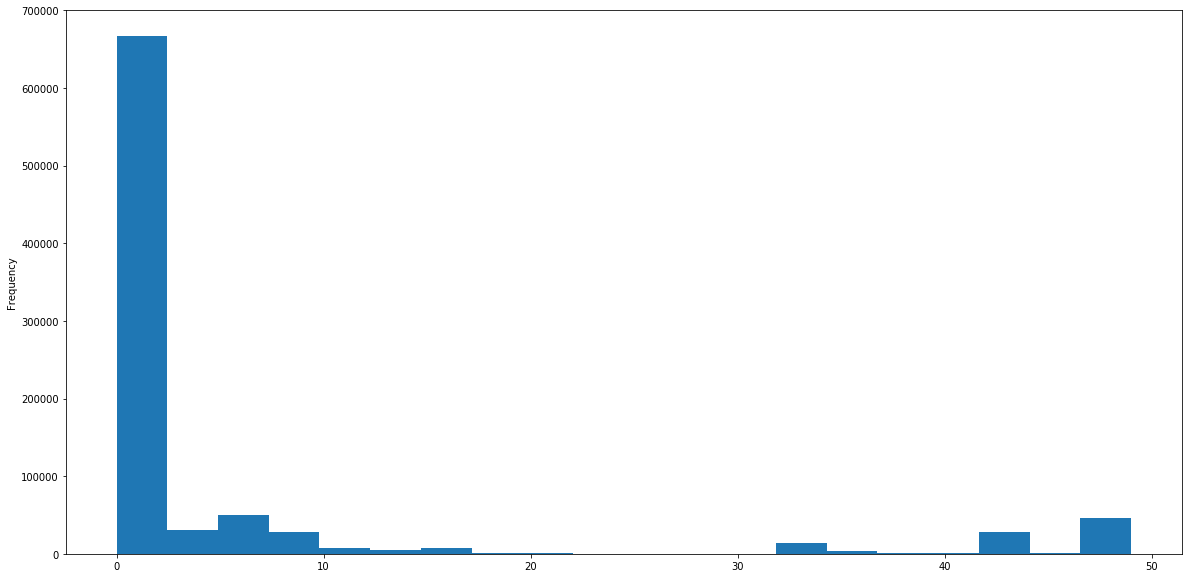

In [26]:
null_values_in_row.plot(kind='hist',figsize=(20,10),bins=20)

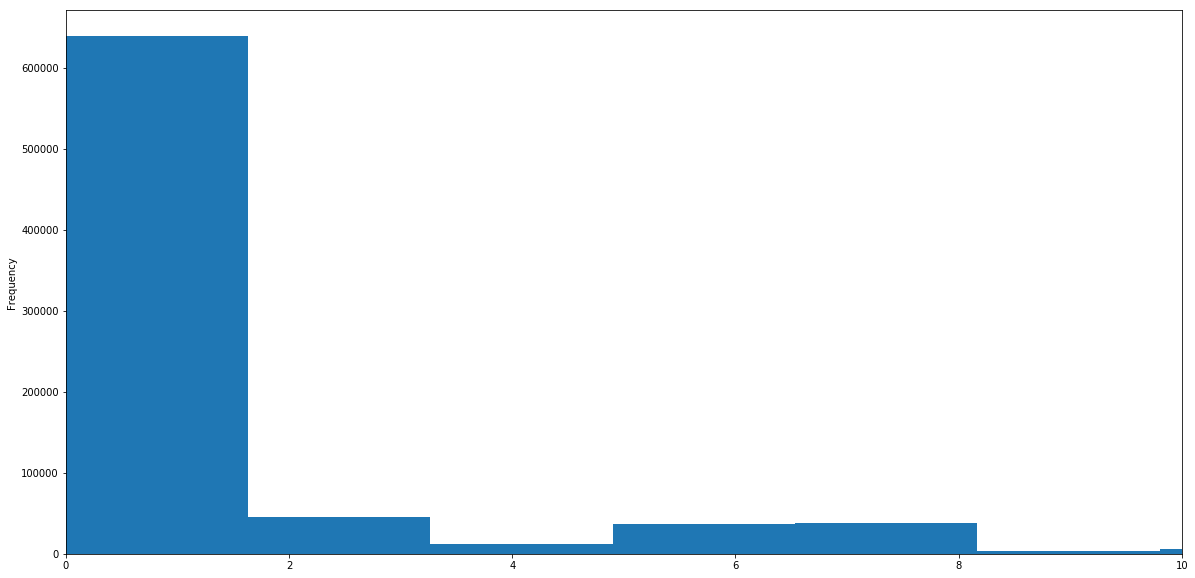

In [27]:
null_values_in_row.plot(kind='hist',figsize=(20,10),bins=30, xlim=(0,10))

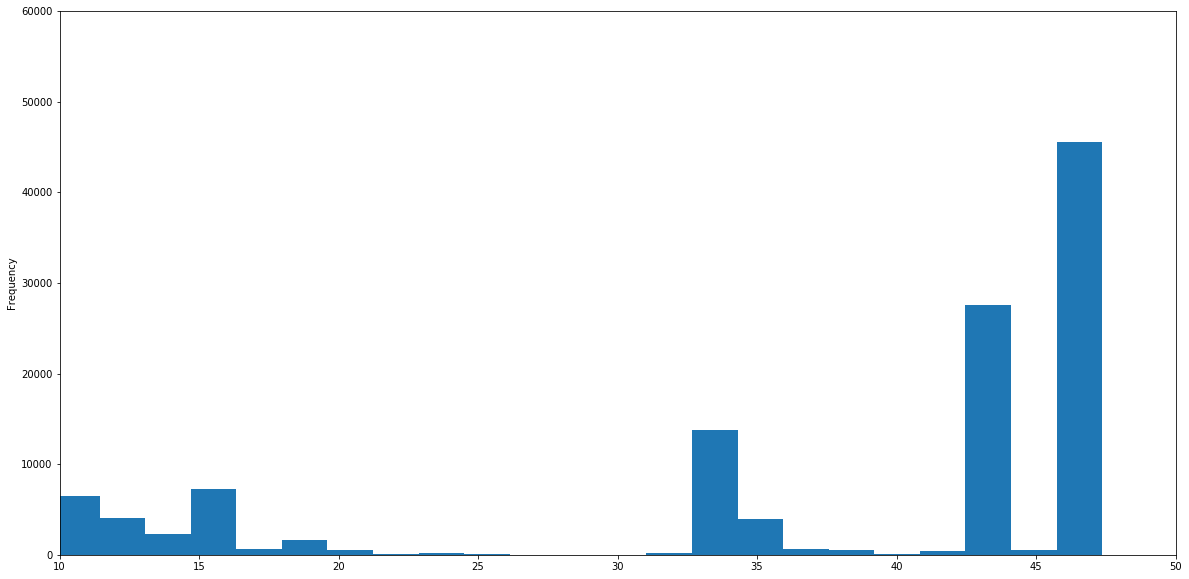

In [28]:
null_values_in_row.plot(kind='hist',figsize=(20,10),bins=30, xlim=(10,50),ylim=(0,60000))

In [42]:
sum = 0
for nulls in null_values_in_row:
    if nulls <= 15:
        sum += 1
        
print("Total number of rows having less than or equal to 27 missing values: {}".format(sum))

Total number of rows having less than or equal to 27 missing values: 792287


In [41]:
sum = 0
for nulls in null_values_in_row:
    if nulls > 27:
        sum += 1
        
print("Total number of rows having greater than 27 missing values: {}".format(sum))

Total number of rows having greater than 27 missing values: 93177


In [43]:
#I have divided the azdias into 2 subsets based on number of missing values as greater than 27 and less than 
#or equal to 27 for comparision

dataset_lessthan = azdias[azdias.index.isin(null_values_in_row[null_values_in_row <= 27].index)]
print(dataset_lessthan.head(5))
print(dataset_lessthan.shape)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   
5                   1.0          2            2.0                  3   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   
5              1                 5               2                      2   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
1                 5     

In [44]:
dataset_lessthan.isnull().sum().sum()

1013699

In [45]:
dataset_greaterthan = azdias[azdias.index.isin(null_values_in_row[null_values_in_row > 27].index)]
print(dataset_greaterthan.head(5))
print(dataset_greaterthan.shape)

    ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                    2.0          1            2.0                  3   
11                   2.0          1            6.0                  3   
14                   3.0          1            6.0                  3   
17                   2.0          1            6.0                  3   
24                   3.0          2            6.0                  3   

    FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0               4                 3               5                      5   
11              4                 3               5                      5   
14              4                 3               5                      5   
17              4                 3               5                      5   
24              4                 3               5                      5   

    FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0          

In [46]:
dataset_greaterthan.isnull().sum().sum()

4021605

In [56]:
# Comparing the distribution of values where there are no or few missing values, between the two subsets.
def compare_dist(column):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    ax = sns.countplot(x = column, data=dataset_lessthan)
    plt.title("<=27 Null Value")
    plt.subplot(122)
    #sns.set(style="darkgrid")
    ax = sns.countplot(x = column, data=dataset_greaterthan)
    plt.title(">27 Null Value")

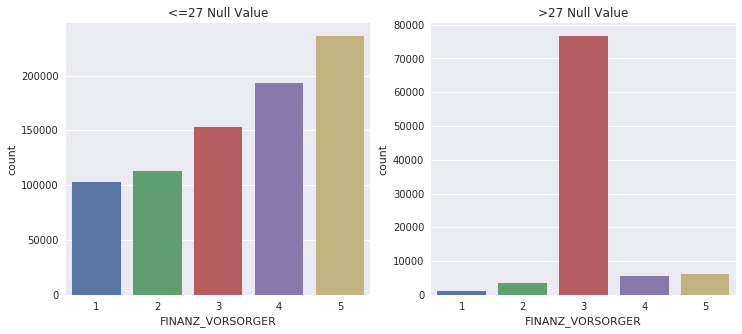

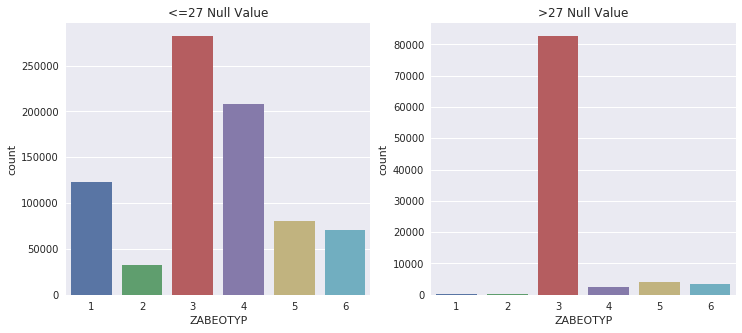

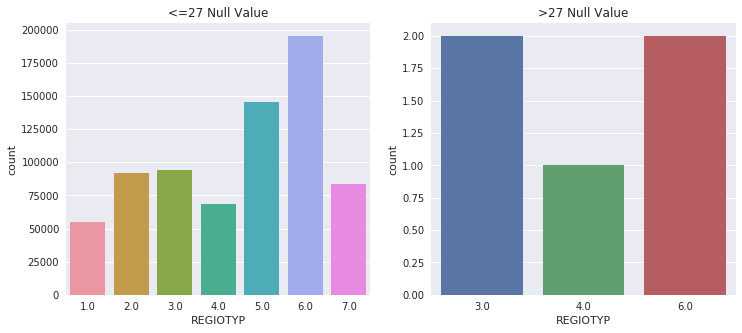

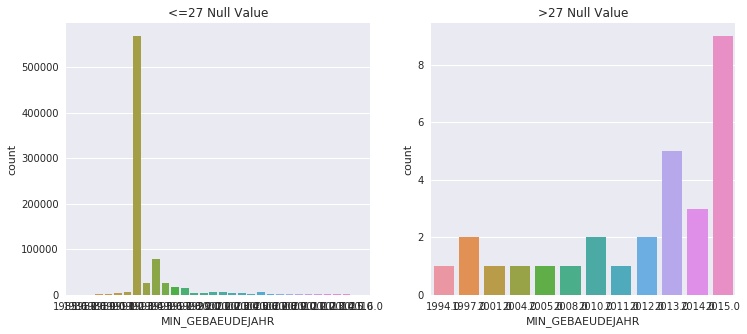

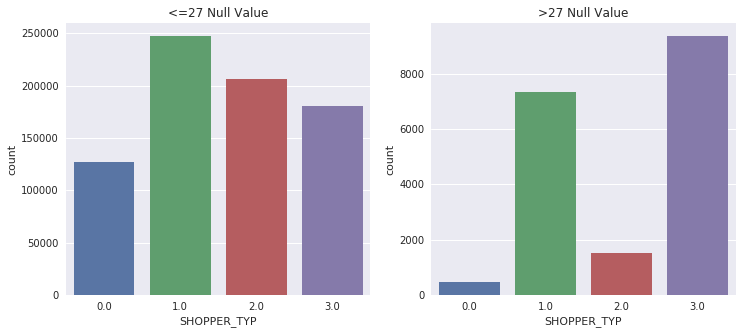

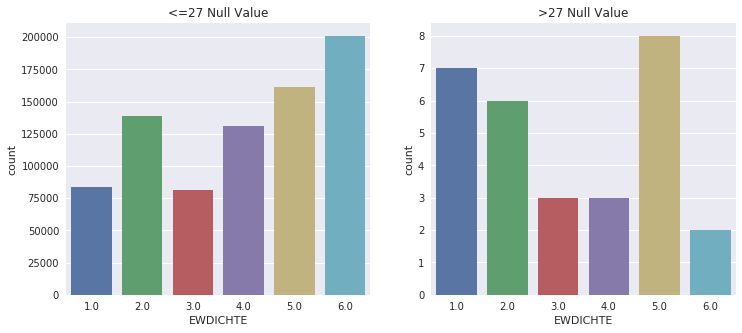

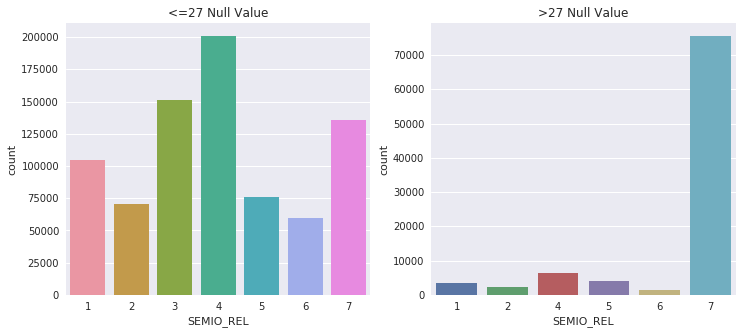

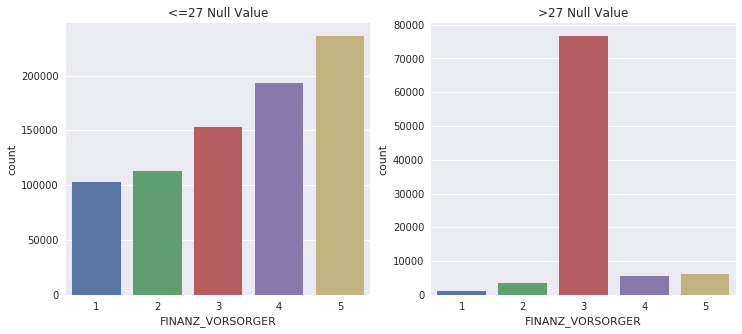

In [58]:
import random
for i in range(8):
    compare_dist(dataset_greaterthan.columns[random.randint(0, 79)])

#### Discussion 1.1.3: Assess Missing Data in Each Row
Out of 891221, 623209 rows have no missing values which is approx 70%.

As you can see there is a large open gap between 10 and 31, I divided the data into 2 subsets with rows with less than or equal to 27 missing values, rows with more than 27 missing values.

The first plot which compares <=27 and >27 missing values shows distinct difference between both the subsets. Thus, using data with lots of missing values can affect the results. So, <=27 is a good subset to be used.

**<=27 allows us to use approx 90% of the data.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I made a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I performed an investigation of the categorical and mixed-type features, and decided whether to keep, drop, or re-encode each. Then, in the last part, I created a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here.

In [59]:
# Number of features of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encoding Categorical Features

In [60]:
# Assessing categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


### Removing the features I deleted in 1.1.2 i.e. 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'

In [61]:
feat_info = feat_info[feat_info.attribute != 'TITEL_KZ']
feat_info = feat_info[feat_info.attribute != 'AGER_TYP']
feat_info = feat_info[feat_info.attribute != 'KK_KUNDENTYP']
feat_info = feat_info[feat_info.attribute != 'KBA05_BAUMAX']
feat_info = feat_info[feat_info.attribute != 'GEBURTSJAHR']
feat_info = feat_info[feat_info.attribute != 'ALTER_HH']

In [62]:
#checking successful removal
feat_info.shape

(79, 4)

In [63]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [48]:
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [64]:
feat_info[feat_info['type'] == 'categorical']['attribute'].count()

#after deleting the features there are 18 categorical features left

18

In [65]:
# Re-encoding the categorical variable(s) to be kept in the analysis.

### Before re-encoding categorical variables we need to separate binary and multi-variable categorical variables.
### Plotting them will help to find the values they hold

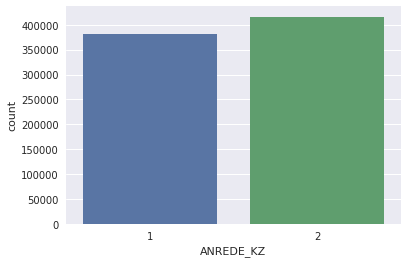

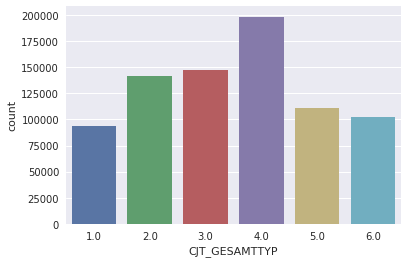

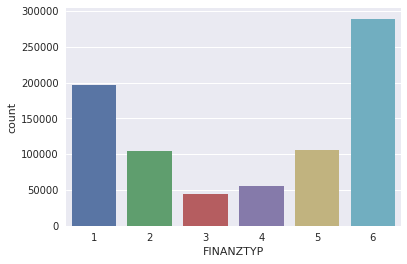

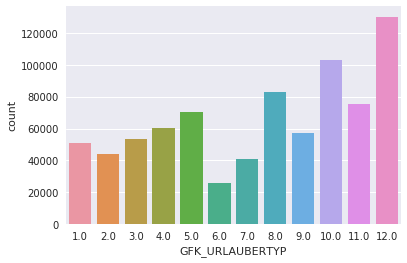

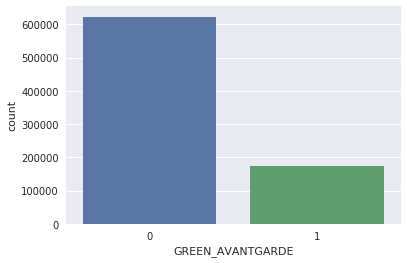

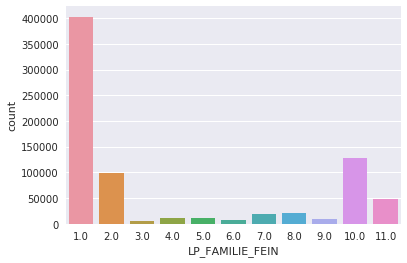

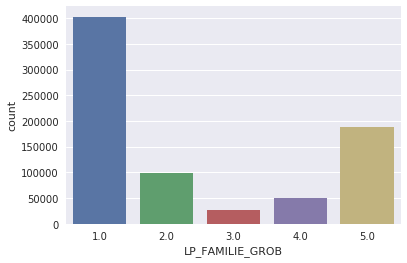

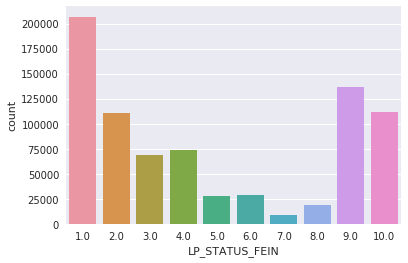

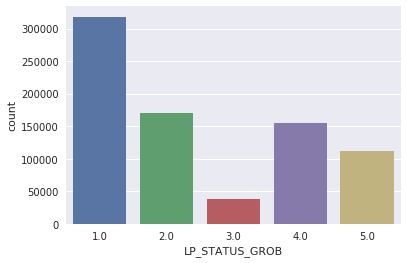

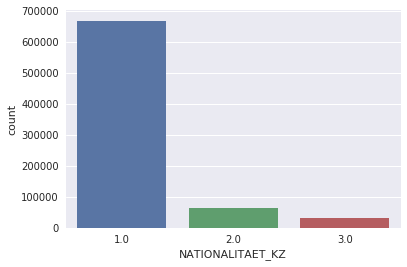

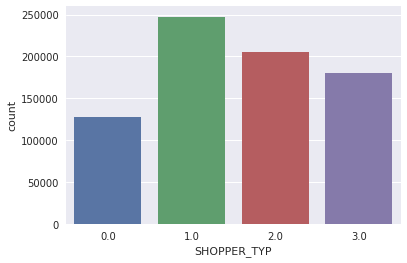

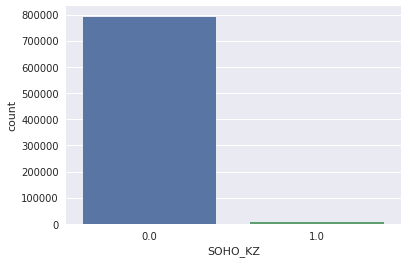

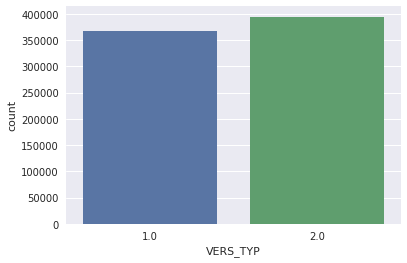

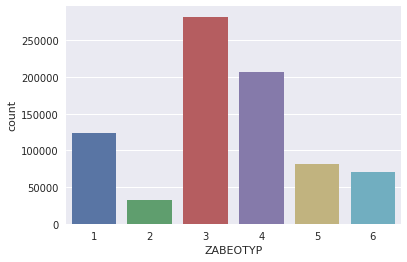

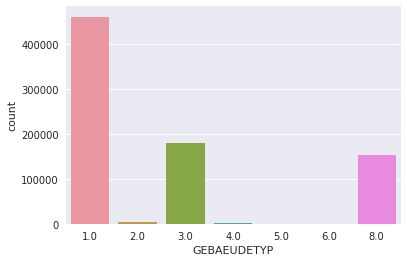

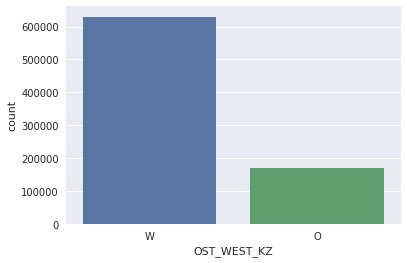

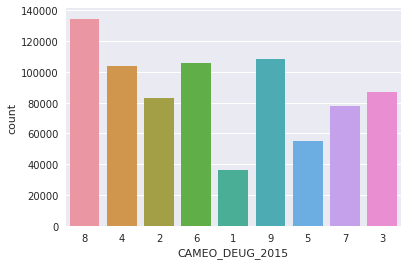

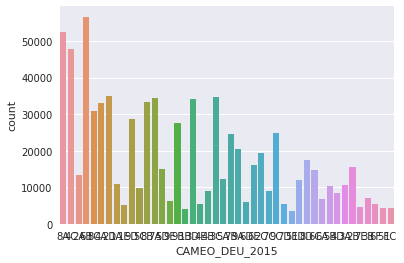

In [66]:
for var in feat_info[feat_info['type'] == 'categorical']['attribute']:
    plot = sns.countplot(x = var, data=dataset_lessthan)
    plt.show()

## As the plot shows:

#### Binary variables are: 
ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ

#### Multi-level categories are: 
CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015

In [67]:
#Mapping OST_WEST_KZ 
dataset_lessthan['OST_WEST_KZ'] = dataset_lessthan['OST_WEST_KZ'].map({'W': 1, 'O': 0})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
dataset_lessthan['OST_WEST_KZ']

1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
12        1
13        1
15        1
16        1
18        1
19        1
20        1
21        1
22        1
23        1
25        1
26        1
27        1
28        1
29        1
31        1
32        1
33        1
34        1
36        1
         ..
891191    1
891192    1
891193    1
891194    1
891195    1
891196    1
891197    1
891198    1
891199    1
891200    1
891201    1
891202    1
891203    1
891204    1
891205    1
891206    1
891207    1
891208    1
891209    1
891210    1
891211    1
891212    1
891213    1
891214    1
891215    1
891216    1
891217    1
891218    1
891219    1
891220    1
Name: OST_WEST_KZ, Length: 798044, dtype: int64

In [69]:
#encoding Multi-level categories:
dataset_lessthan = pd.get_dummies(dataset_lessthan, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 
                                             'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                                             'ZABEOTYP', 'CAMEO_DEUG_2015'])

In [70]:
#dropping unwanted features
dataset_lessthan = dataset_lessthan.drop(['LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEU_2015'], axis = 1)

In [71]:
dataset_lessthan.shape

(798044, 123)

#### Discussion 1.2.1: Re-Encode Categorical Features

There were 18 features, out of which **5 were birany features** (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ) and **13 were multi-level features** (CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015)

Only 'OST_WEST_KZ' was the binary variables which needed mapping as it took w and o as input.

I encoded 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015' multi level varibales which I thought are required for further analysis and removed the 3 multi-level variables 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEU_2015'

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [72]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [73]:
# Investigating "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
dataset_lessthan['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182980
8.0     141625
10.0     85807
5.0      84691
3.0      53844
15.0     42545
11.0     35751
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

### Data dictionary shows that numbers 1,3,5,8,10,12,14 are mainstream while others are avantgarde
### Using this information to engineer movement, 0 denotes mainstream and 1 denotes avantgarde

In [75]:
#Engineering PRAEGENDE_JUGENDJAHRE['AVANTGARDE']

avantgarde_mainstream = []

for var in dataset_lessthan['PRAEGENDE_JUGENDJAHRE']:
    if var in [1,3,5,8,10,12,14]:
        avantgarde_mainstream.append(0) 
    elif var in [2,4,6,7,9,11,13,15]:
        avantgarde_mainstream.append(1)
    else:
        avantgarde_mainstream.append(np.nan)

In [76]:
avantgarde_mainstream = pd.Series(avantgarde_mainstream)
dataset_lessthan['AVANTGARDE'] = avantgarde_mainstream.values

In [77]:
dataset_lessthan['AVANTGARDE']

1         0.0
2         1.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         1.0
9         1.0
10        0.0
12        0.0
13        1.0
15        0.0
16        0.0
18        0.0
19        1.0
20        1.0
21        0.0
22        0.0
23        1.0
25        0.0
26        0.0
27        1.0
28        0.0
29        1.0
31        0.0
32        1.0
33        0.0
34        1.0
36        0.0
         ... 
891191    0.0
891192    0.0
891193    0.0
891194    1.0
891195    0.0
891196    0.0
891197    1.0
891198    1.0
891199    0.0
891200    0.0
891201    0.0
891202    0.0
891203    NaN
891204    0.0
891205    0.0
891206    0.0
891207    1.0
891208    0.0
891209    0.0
891210    0.0
891211    0.0
891212    0.0
891213    1.0
891214    0.0
891215    0.0
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: AVANTGARDE, Length: 798044, dtype: float64

In [78]:
#Engineering PRAEGENDE_JUGENDJAHRE['DECADE']

dataset_lessthan['DECADE'] = dataset_lessthan['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,
                                                                          10:5,11:5,12:5,13:5,14:6,15:6})

In [79]:
dataset_lessthan['DECADE']

1         6.0
2         6.0
3         4.0
4         4.0
5         2.0
6         5.0
7         4.0
8         5.0
9         6.0
10        2.0
12        4.0
13        6.0
15        3.0
16        6.0
18        5.0
19        4.0
20        5.0
21        5.0
22        6.0
23        4.0
25        6.0
26        4.0
27        5.0
28        5.0
29        3.0
31        5.0
32        6.0
33        4.0
34        2.0
36        4.0
         ... 
891191    2.0
891192    6.0
891193    3.0
891194    5.0
891195    4.0
891196    6.0
891197    5.0
891198    6.0
891199    5.0
891200    6.0
891201    5.0
891202    5.0
891203    NaN
891204    5.0
891205    2.0
891206    6.0
891207    1.0
891208    4.0
891209    6.0
891210    4.0
891211    4.0
891212    2.0
891213    5.0
891214    6.0
891215    5.0
891216    6.0
891217    5.0
891218    6.0
891219    6.0
891220    2.0
Name: DECADE, Length: 798044, dtype: float64

In [80]:
dataset_lessthan.shape #shows 2 columns are added

(798044, 125)

In [81]:
#Dropping Old PRAEGENDE_JUGENDJAHRE
dataset_lessthan = dataset_lessthan.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [82]:
dataset_lessthan[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,6.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,1.0,6.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1,0,0,0,0,0,0,0,0.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,0,0,0.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,2.0


In [83]:
dataset_lessthan.shape #shows 1 column has been deleted

(798044, 124)

In [84]:
# Investigating "CAMEO_INTL_2015" and engineer two new variables.
dataset_lessthan['CAMEO_INTL_2015']

1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
12         43
13         33
15         41
16         41
18         24
19         34
20         24
21         55
22         51
23         43
25         33
26        NaN
27         51
28         13
29         12
31         51
32         14
33         41
34         25
36         41
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 798044, dtype: object

In [85]:
#Engineering CAMEO_INTL_2015

CAMEO_WEALTH=[]
CAMEO_LIFESTAGE=[]

for var in dataset_lessthan['CAMEO_INTL_2015']:
    var = float(var)
    
    if 10 < var < 16:
        CAMEO_WEALTH.append(1)
    elif 20 < var < 26:
        CAMEO_WEALTH.append(2)
    elif 30 < var < 36:
        CAMEO_WEALTH.append(3)
    elif 40 < var < 46:
        CAMEO_WEALTH.append(4)
    elif 50 < var < 56:
        CAMEO_WEALTH.append(5)
    else:
        CAMEO_WEALTH.append(np.nan)
        
    result = var%10
        
    if result == 1:
        CAMEO_LIFESTAGE.append(1)
    elif result == 2:
        CAMEO_LIFESTAGE.append(2)
    elif result == 3:
        CAMEO_LIFESTAGE.append(3)
    elif result == 4:
        CAMEO_LIFESTAGE.append(4)
    elif result == 5:
        CAMEO_LIFESTAGE.append(5)
    else:
        CAMEO_LIFESTAGE.append(np.nan)

In [86]:
print(CAMEO_LIFESTAGE[:28])

[1, 4, 2, 3, 4, 2, 4, 3, 5, 1, 3, 3, 1, 1, 4, 4, 4, 5, 1, 3, 3, nan, 1, 3, 2, 1, 4, 1]


In [87]:
print(CAMEO_WEALTH[:28])

[5, 2, 1, 4, 5, 2, 1, 1, 1, 5, 4, 3, 4, 4, 2, 3, 2, 5, 5, 4, 3, nan, 5, 1, 1, 5, 1, 4]


In [88]:
CAMEO_WEALTH = pd.Series(CAMEO_WEALTH)
CAMEO_LIFESTAGE = pd.Series(CAMEO_LIFESTAGE)

In [89]:
dataset_lessthan['CAMEO_INTL_2015_WEALTH'] = CAMEO_WEALTH.values
dataset_lessthan['CAMEO_INTL_2015_LIFESTAGE'] = CAMEO_LIFESTAGE.values

In [90]:
dataset_lessthan['CAMEO_INTL_2015_WEALTH'][:5] #Assuring successful addition of wealth column

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [91]:
dataset_lessthan['CAMEO_INTL_2015_LIFESTAGE'][:5] #Assuring successful addition of lifestage column

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

In [92]:
dataset_lessthan.shape #shows addition of 2 rows

(798044, 126)

In [93]:
dataset_lessthan[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,0.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,1.0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,0.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0.0,2.0,5.0,4.0


In [94]:
#Dropping Old CAMEO_INTL_2015
dataset_lessthan = dataset_lessthan.drop('CAMEO_INTL_2015',axis=1)

In [95]:
dataset_lessthan.shape #shows one row has been deleted

(798044, 125)

In [96]:
#Dropping other mixed categorical features which will not be used for analysis

dataset_lessthan = dataset_lessthan.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], 
                                       axis = 1)

In [97]:
dataset_lessthan.head() 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,0.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,1.0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,0.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0.0,2.0,5.0,4.0


In [98]:
dataset_lessthan.shape #shows 4 columns has been deleted

(798044, 121)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I re-engineered 2 features namely 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' and dropped the other mixed-type features 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'

**PRAEGENDE_JUGENDJAHRE** was divided into DECADE and AVANTGRADE.
**CAMEO_INTL_2015** was divided into CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE

After re-engineering, the new columns were added to the subset and old columns were deleted.

I thought of removing all the other mixed-typefeatures because I felt they are of less relevance to the analysis.

#### Step 1.2.3: Complete Feature Selection

In [99]:
#As all the values were not visible when I called encoded_dataset[:1], I created this function to view all the values
first_row = dataset_lessthan.iloc[0]
for index, value in enumerate(first_row.iteritems()):
    print(index, value)

0 ('ALTERSKATEGORIE_GROB', 1.0)
1 ('ANREDE_KZ', 2.0)
2 ('FINANZ_MINIMALIST', 1.0)
3 ('FINANZ_SPARER', 5.0)
4 ('FINANZ_VORSORGER', 2.0)
5 ('FINANZ_ANLEGER', 5.0)
6 ('FINANZ_UNAUFFAELLIGER', 4.0)
7 ('FINANZ_HAUSBAUER', 5.0)
8 ('GREEN_AVANTGARDE', 0.0)
9 ('HEALTH_TYP', 3.0)
10 ('LP_FAMILIE_FEIN', 5.0)
11 ('RETOURTYP_BK_S', 1.0)
12 ('SEMIO_SOZ', 5.0)
13 ('SEMIO_FAM', 4.0)
14 ('SEMIO_REL', 4.0)
15 ('SEMIO_MAT', 3.0)
16 ('SEMIO_VERT', 1.0)
17 ('SEMIO_LUST', 2.0)
18 ('SEMIO_ERL', 2.0)
19 ('SEMIO_KULT', 3.0)
20 ('SEMIO_RAT', 6.0)
21 ('SEMIO_KRIT', 4.0)
22 ('SEMIO_DOM', 7.0)
23 ('SEMIO_KAEM', 4.0)
24 ('SEMIO_PFLICHT', 7.0)
25 ('SEMIO_TRADV', 6.0)
26 ('SOHO_KZ', 1.0)
27 ('VERS_TYP', 2.0)
28 ('ANZ_PERSONEN', 2.0)
29 ('ANZ_TITEL', 0.0)
30 ('HH_EINKOMMEN_SCORE', 6.0)
31 ('W_KEIT_KIND_HH', 3.0)
32 ('WOHNDAUER_2008', 9.0)
33 ('ANZ_HAUSHALTE_AKTIV', 11.0)
34 ('ANZ_HH_TITEL', 0.0)
35 ('KONSUMNAEHE', 1.0)
36 ('MIN_GEBAEUDEJAHR', 1992.0)
37 ('OST_WEST_KZ', 1.0)
38 ('KBA05_ANTG1', 0.0)
39 ('KBA05_ANTG2', 

#### Found 2 features which have large values: MIN_GEBAEUDEJAHR and KBA13_ANZAHL_PKW
#### Examining them to decide whether to remove or not

In [100]:
feat_info[feat_info['attribute'] == 'KBA13_ANZAHL_PKW']

,attribute,information_level,type,missing_or_unknown
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


In [101]:
feat_info[feat_info['attribute'] == 'MIN_GEBAEUDEJAHR']

,attribute,information_level,type,missing_or_unknown
54,MIN_GEBAEUDEJAHR,building,numeric,[0]


#### As the subset must contain all the numeric, interval, and ordinal type columns from the original dataset I will not delete both the columns

In [102]:
dataset_lessthan.shape

(798044, 121)

In [103]:
nulls = dataset_lessthan.isnull().sum()
nulls.sum()

794379

In [104]:
nulls_proportion = nulls/dataset_lessthan.shape[0] * 100

In [105]:
nulls_proportion.sort_values(ascending=False)

REGIOTYP                     8.131381
KKK                          8.131381
W_KEIT_KIND_HH               7.430292
KBA05_ANTG4                  5.030675
MOBI_REGIO                   5.030675
KBA05_GBZ                    5.030675
KBA05_ANTG3                  5.030675
KBA05_ANTG1                  5.030675
KBA05_ANTG2                  5.030675
VERS_TYP                     4.600624
HEALTH_TYP                   4.600624
LP_FAMILIE_FEIN              3.941011
AVANTGARDE                   3.602684
DECADE                       3.602684
PLZ8_ANTG3                   2.924400
PLZ8_GBZ                     2.924400
PLZ8_HHZ                     2.924400
PLZ8_ANTG4                   2.924400
PLZ8_ANTG1                   2.924400
PLZ8_ANTG2                   2.924400
KBA13_ANZAHL_PKW             1.581993
ANZ_HAUSHALTE_AKTIV          0.809229
CAMEO_INTL_2015_LIFESTAGE    0.774769
CAMEO_INTL_2015_WEALTH       0.774769
ONLINE_AFFINITAET            0.593075
RETOURTYP_BK_S               0.593075
ARBEIT      

### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, I'll need to perform the same cleaning steps on the customer demographics data. So, I'm creating a cleaning function, so, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [106]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    

    # converting missing value codes into NaNs, ...
    
    for index, value in enumerate(df.iteritems()):
        unknown_data = feat_info['missing_or_unknown'][index]
        columns = value[0]
        unknown_data = unknown_data[1:-1].split(',')
        if unknown_data != ['']:
            new_var = []
            for x in unknown_data:
                if x in ['X','XX']:
                    new_var.append(x)
                else:
                    new_var.append(int(x))
            df[columns] = df[columns].replace(new_var, np.nan)


    # removing selected columns and rows, ...
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'],axis=1)
    null_values_in_row = df.isnull().sum(axis=1)
    df = df[df.index.isin(null_values_in_row[null_values_in_row <= 5].index)]

    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = pd.get_dummies(df, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 
                                             'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                                             'ZABEOTYP', 'CAMEO_DEUG_2015'])
    df = df.drop(['LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEU_2015'], axis = 1)
    
    #Engineering PRAEGENDE_JUGENDJAHRE['AVANTGARDE']
    avantgarde_mainstream = []
    for var in df['PRAEGENDE_JUGENDJAHRE']:
        if var in [1,3,5,8,10,12,14]:
            avantgarde_mainstream.append(0) 
        elif var in [2,4,6,7,9,11,13,15]:
            avantgarde_mainstream.append(1)
        else:
            avantgarde_mainstream.append(np.nan)
    
    avantgarde_mainstream = pd.Series(avantgarde_mainstream)
    df['AVANTGARDE'] = avantgarde_mainstream.values  
    
    #Engineering PRAEGENDE_JUGENDJAHRE['DECADE']
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,
                                                    10:5,11:5,12:5,13:5,14:6,15:6})
    
    # Engineering CAMEO_INTL_2015
    CAMEO_WEALTH=[]
    CAMEO_LIFESTAGE=[]

    for var in df['CAMEO_INTL_2015']:
        var = float(var)
    
        if 10 < var < 16:
            CAMEO_WEALTH.append(1)
        elif 20 < var < 26:
            CAMEO_WEALTH.append(2)
        elif 30 < var < 36:
            CAMEO_WEALTH.append(3)
        elif 40 < var < 46:
            CAMEO_WEALTH.append(4)
        elif 50 < var < 56:
            CAMEO_WEALTH.append(5)
        else:
            CAMEO_WEALTH.append(np.nan)
        
        result = var%10
        
        if result == 1:
            CAMEO_LIFESTAGE.append(1)
        elif result == 2:
            CAMEO_LIFESTAGE.append(2)
        elif result == 3:
            CAMEO_LIFESTAGE.append(3)
        elif result == 4:
            CAMEO_LIFESTAGE.append(4)
        elif result == 5:
            CAMEO_LIFESTAGE.append(5)
        else:
            CAMEO_LIFESTAGE.append(np.nan)

    CAMEO_WEALTH = pd.Series(CAMEO_WEALTH)
    CAMEO_LIFESTAGE = pd.Series(CAMEO_LIFESTAGE)

    df['CAMEO_INTL_2015_WEALTH'] = CAMEO_WEALTH.values
    df['CAMEO_INTL_2015_LIFESTAGE'] = CAMEO_LIFESTAGE.values
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE',
                 'CAMEO_INTL_2015'], axis = 1)
    
    # Returning the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [107]:
dataset_lessthan.isnull().sum().sum()

794379

In [108]:
#Creating list of column names for later use

column_name = list(dataset_lessthan.columns.values)
column_name

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_FAMILIE_FEIN',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT

In [109]:
#Verifying the count of names in column_name list
count = 0
for name in column_name:
    count += 1
count

121

In [110]:
# Applying feature scaling to the general population demographics data.
from sklearn.preprocessing import Imputer, StandardScaler

imputer = Imputer()
dataset_lessthan = imputer.fit_transform(dataset_lessthan)
scaler = StandardScaler()
dataset_lessthan = scaler.fit_transform(dataset_lessthan)

In [111]:
dataset_lessthan

array([[-1.76605793,  0.9579123 , -1.49459467, ...,  1.16568491,
         1.19130634, -1.26640924],
       [ 0.20124175,  0.9579123 , -1.49459467, ...,  1.16568491,
        -0.86516434,  0.76198   ],
       [ 1.1848916 ,  0.9579123 ,  0.68314621, ..., -0.23201743,
        -1.55065457, -0.5902795 ],
       ..., 
       [-0.78240809,  0.9579123 , -0.76868104, ...,  1.16568491,
        -0.86516434,  0.76198   ],
       [-1.76605793, -1.0439369 , -1.49459467, ...,  1.16568491,
         1.19130634, -1.26640924],
       [ 1.1848916 , -1.0439369 ,  0.68314621, ..., -1.62971976,
         0.50581611,  0.08585025]])

In [112]:
#Converting dataset_lessthan to DataFrame
dataset_lessthan = pd.DataFrame(dataset_lessthan, columns=column_name)

In [113]:
dataset_lessthan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-1.766058,0.957912,-1.494595,1.537929,-1.040689,1.465976,0.958673,1.339299,-0.530411,1.085940,...,-0.386910,-0.272886,-0.391100,-0.328974,2.221715,-0.395991,-0.553150,1.165685,1.191306,-1.266409
1,0.201242,0.957912,-1.494595,0.864570,-1.766973,-0.570993,0.244142,1.339299,1.885331,1.085940,...,2.584584,-0.272886,-0.391100,-0.328974,-0.450103,-0.395991,1.875393,1.165685,-0.865164,0.761980
2,1.184892,0.957912,0.683146,-0.482150,1.138164,-0.570993,-1.184919,-0.791237,-0.530411,-0.269825,...,-0.386910,-0.272886,-0.391100,-0.328974,-0.450103,-0.395991,-0.553150,-0.232017,-1.550655,-0.590279
3,0.201242,-1.043937,0.683146,0.191210,0.411880,-1.249983,0.244142,-0.791237,-0.530411,1.085940,...,-0.386910,-0.272886,2.556888,-0.328974,-0.450103,-0.395991,-0.553150,-0.232017,0.505816,0.085850
4,-1.766058,0.957912,-0.042767,-1.155509,1.138164,-0.570993,-0.470389,1.339299,-0.530411,1.085940,...,-0.386910,-0.272886,-0.391100,-0.328974,2.221715,-0.395991,-0.553150,-1.629720,1.191306,0.761980


In [114]:
dataset_lessthan.isnull().sum().sum()

0

In [116]:
#Saving csv with no null values
dataset_lessthan.to_csv('cleaned_original.csv',sep=';',encoding='utf-8',index=False)

In [117]:
dataset_lessthan.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
count,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,...,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05,7.980440e+05
mean,4.860806e-16,1.289991e-16,-2.172467e-18,-1.028717e-16,2.134004e-16,1.496687e-17,-1.078933e-16,6.513840e-17,1.359573e-17,-5.310079e-17,...,-4.950821e-17,7.309817e-17,2.396837e-17,4.414382e-17,-1.553670e-17,-5.492157e-17,-2.012203e-18,-8.591929e-17,-4.872113e-16,6.440831e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766058e+00,-1.043937e+00,-1.494595e+00,-1.155509e+00,-1.766973e+00,-1.249983e+00,-1.184919e+00,-1.501415e+00,-5.304108e-01,-1.625589e+00,...,-3.869095e-01,-2.728858e-01,-3.911004e-01,-3.289735e-01,-4.501028e-01,-3.959905e-01,-5.531497e-01,-2.328571e+00,-1.550655e+00,-1.266409e+00
25%,-7.824081e-01,-1.043937e+00,-7.686810e-01,-1.155509e+00,-1.040689e+00,-1.249983e+00,-1.184919e+00,-7.912368e-01,-5.304108e-01,-2.698248e-01,...,-3.869095e-01,-2.728858e-01,-3.911004e-01,-3.289735e-01,-4.501028e-01,-3.959905e-01,-5.531497e-01,-9.308686e-01,-8.651643e-01,-1.266409e+00
50%,2.012418e-01,9.579123e-01,-4.276742e-02,1.912101e-01,4.118797e-01,1.079968e-01,-4.703886e-01,-8.105823e-02,-5.304108e-01,-2.698248e-01,...,-3.869095e-01,-2.728858e-01,-3.911004e-01,-3.289735e-01,-4.501028e-01,-3.959905e-01,-5.531497e-01,0.000000e+00,5.058161e-01,8.585025e-02
75%,1.184892e+00,9.579123e-01,6.831462e-01,8.645697e-01,1.138164e+00,7.869865e-01,9.586726e-01,6.291203e-01,-5.304108e-01,1.085940e+00,...,-3.869095e-01,-2.728858e-01,-3.911004e-01,-3.289735e-01,-4.501028e-01,-3.959905e-01,6.740561e-17,1.165685e+00,1.191306e+00,7.619800e-01
max,1.184892e+00,9.579123e-01,1.409060e+00,1.537929e+00,1.138164e+00,1.465976e+00,1.673203e+00,1.339299e+00,1.885331e+00,1.085940e+00,...,2.584584e+00,3.664536e+00,2.556888e+00,3.039758e+00,2.221715e+00,2.525313e+00,1.875393e+00,1.165685e+00,1.191306e+00,1.438110e+00


### Discussion 2.1: Apply Feature Scaling)

I used StandardScaler instance for scaling each feature to mean 0 and standard deviation 1 which helped to remove all the NaN values and obtain a scaled dataset with no null values

### Step 2.2: Perform Dimensionality Reduction

In [118]:
# Applying PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
dataset_pca = pca.fit_transform(dataset_lessthan)

In [128]:
# Investigating the variance accounted for by each principal component.
    
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    print("This shows percentage of variance offered by the number of principal components")
    for i in range(1, num_components):
        required_variance = cumvals[i-1]*100
        print("{} components have {}% of the variance".format(i, round(cumvals[i-1]*100)))

This shows percentage of variance offered by the number of principal components
1 components have 11.0% of the variance
2 components have 20.0% of the variance
3 components have 25.0% of the variance
4 components have 29.0% of the variance
5 components have 32.0% of the variance
6 components have 34.0% of the variance
7 components have 36.0% of the variance
8 components have 37.0% of the variance
9 components have 39.0% of the variance
10 components have 41.0% of the variance
11 components have 42.0% of the variance
12 components have 44.0% of the variance
13 components have 45.0% of the variance
14 components have 46.0% of the variance
15 components have 47.0% of the variance
16 components have 49.0% of the variance
17 components have 50.0% of the variance
18 components have 51.0% of the variance
19 components have 52.0% of the variance
20 components have 53.0% of the variance
21 components have 54.0% of the variance
22 components have 55.0% of the variance
23 components have 56.0% of

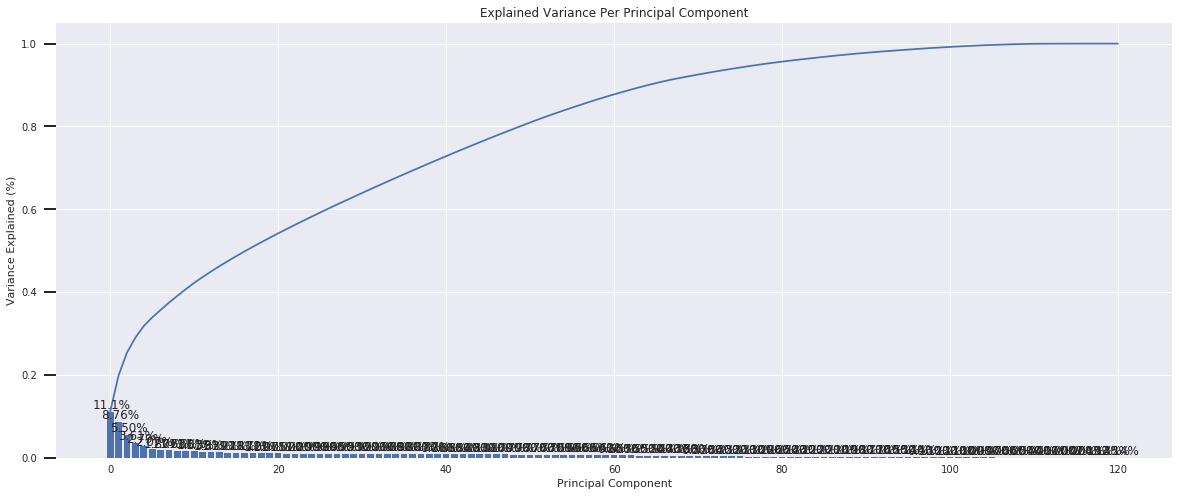

In [129]:
scree_plot(pca)

In [130]:
# Re-applying PCA to the data while selecting for number of components to retain.

#Selected number of components are 78
pca_78 = PCA(n_components=78)
dataset_lessthan_pca = pca_78.fit_transform(dataset_lessthan)

This shows percentage of variance offered by the number of principal components
1 components have 11.0% of the variance
2 components have 20.0% of the variance
3 components have 25.0% of the variance
4 components have 29.0% of the variance
5 components have 32.0% of the variance
6 components have 34.0% of the variance
7 components have 36.0% of the variance
8 components have 37.0% of the variance
9 components have 39.0% of the variance
10 components have 41.0% of the variance
11 components have 42.0% of the variance
12 components have 44.0% of the variance
13 components have 45.0% of the variance
14 components have 46.0% of the variance
15 components have 47.0% of the variance
16 components have 49.0% of the variance
17 components have 50.0% of the variance
18 components have 51.0% of the variance
19 components have 52.0% of the variance
20 components have 53.0% of the variance
21 components have 54.0% of the variance
22 components have 55.0% of the variance
23 components have 56.0% of

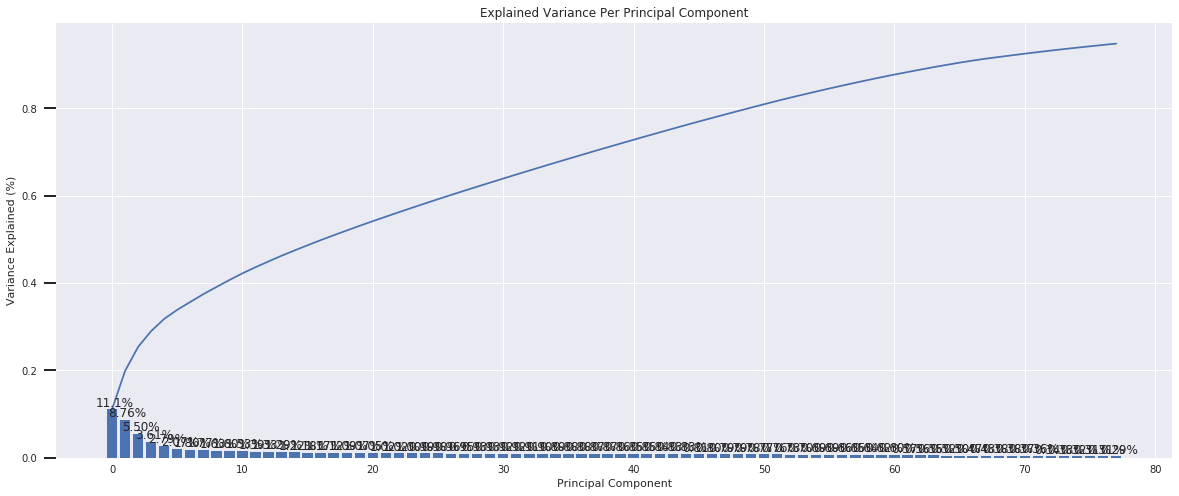

In [131]:
scree_plot(pca_78)

### Discussion 2.2: Perform Dimensionality Reduction

The output shows 78 principal components gives **95% cumulative variance**. 

So, I'll selected 78 as the number of principal components which will help to retrieve most of the characteristics of dataset.

### Step 2.3: Interpret Principal Components

In [133]:
# Mapping weights for the first principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

def weights(num):
    print("Principal Component: {}".format(num))
    if num == 0:
        comp = pd.DataFrame(np.round(pca_78.components_[0:1], 4), columns = column_name)
    else:
        comp = pd.DataFrame(np.round(pca_78.components_[num - 1: num], 4), columns = column_name)
    comp.index = ['Weights']
    comp = comp.sort_values(by = 'Weights', axis = 1, ascending=False)
    comp = comp.T
    return comp

weights(1)

Principal Component: 1


,Weights
LP_STATUS_GROB_1.0,0.2022
HH_EINKOMMEN_SCORE,0.1915
PLZ8_ANTG3,0.1902
CAMEO_INTL_2015_WEALTH,0.1884
PLZ8_ANTG4,0.1838
ORTSGR_KLS9,0.1621
EWDICHTE,0.1608
FINANZ_HAUSBAUER,0.1480
FINANZ_SPARER,0.1433
FINANZTYP_1,0.1326


In [134]:
# Mapping weights for the second principal component to corresponding feature names
# and then printing the linked values, sorted by weight.
weights(2)

Principal Component: 2


,Weights
ALTERSKATEGORIE_GROB,0.2269
FINANZ_VORSORGER,0.2122
ZABEOTYP_3,0.2045
SEMIO_ERL,0.1862
SEMIO_LUST,0.1604
RETOURTYP_BK_S,0.1538
W_KEIT_KIND_HH,0.1314
FINANZ_HAUSBAUER,0.1132
CJT_GESAMTTYP_2.0,0.1066
FINANZTYP_5,0.0951


In [135]:
# Mapping weights for the third principal component to corresponding feature names
# and then printing the linked values, sorted by weight.
weights(3)

Principal Component: 3


,Weights
SEMIO_VERT,0.3253
SEMIO_FAM,0.2593
SEMIO_SOZ,0.2585
SEMIO_KULT,0.2486
FINANZTYP_5,0.1377
FINANZ_MINIMALIST,0.1307
SHOPPER_TYP_0.0,0.1266
ZABEOTYP_1,0.1076
SEMIO_REL,0.1028
RETOURTYP_BK_S,0.0856


In [136]:
weights(4)

Principal Component: 4


,Weights
GREEN_AVANTGARDE,0.3138
AVANTGARDE,0.3135
LP_STATUS_GROB_5.0,0.2457
EWDICHTE,0.2423
ORTSGR_KLS9,0.2352
LP_FAMILIE_FEIN,0.1974
ANZ_PERSONEN,0.1831
LP_FAMILIE_GROB_5.0,0.1652
ONLINE_AFFINITAET,0.1435
PLZ8_ANTG3,0.1238


In [137]:
weights(5)

Principal Component: 5


,Weights
LP_FAMILIE_FEIN,0.3604
ANZ_PERSONEN,0.3143
LP_FAMILIE_GROB_5.0,0.3111
KKK,0.2197
FINANZTYP_6,0.1760
REGIOTYP,0.1697
ONLINE_AFFINITAET,0.1248
CAMEO_INTL_2015_WEALTH,0.1076
LP_FAMILIE_GROB_4.0,0.1034
LP_STATUS_GROB_4.0,0.1032


## Discussion 2.3: Interpret Principal Components

### Positive and Negative most prominent features:

### Principal Component: 1
**Most Prominent-** 

LP_STATUS_GROB_1.0: 	0.2022 (low-income earners)

HH_EINKOMMEN_SCORE:	0.1915 (Estimated household net income)

PLZ8_ANTG3:	0.1902 (Number of 6-10 family houses in the PLZ8 region)

**Least Prominent-** 

MOBI_REGIO: 	-0.2116 (Movement patterns)

FINANZ_MINIMALIST:	-0.2097 (Financial typology, low financial interest)

KBA05_ANTG1:	-0.1984 (Number of 1-2 family houses in the microcell)

**The above most and least prominent features shows the principal component 1 is related to region. Principal component 1 has positive correlation with high income and more number of houses in that region and have negative correlation with low income and low number of houses**


### Principal Component: 2
**Most Prominent-** 

ALTERSKATEGORIE_GROB:	0.2269 (Estimated age based on given name analysis)

FINANZ_VORSORGER:	0.2122 (Financial typology, be prepared)

ZABEOTYP_3:	0.2045 (Energy consumption typology, fair supplied)

SEMIO_ERL:	0.1862 (Personality typology, event-oriented)

SEMIO_LUST:	0.1604 (Personality typology, sensual-minded)
                    
**Least Prominent-** 

DECADE:	-0.2313 (Person's Youth)

FINANZ_SPARER:	-0.2131 (Financial typology, money-saver)

SEMIO_REL:	-0.2124 (Personality typology, religious)

FINANZ_UNAUFFAELLIGER:	-0.2109 (Financial typology, inconspicuous)

SEMIO_TRADV:	-0.2052 (Personality typology, tradional-minded)

**The above most and least prominent features shows the principal component 2 is related to people between 30-60 years of age. Principal component 2 is positively correlated to person's financial stability and shopping habits and negatively correlated to their self principles and religious beliefs.**


### Principal Component: 3
**Most Prominent-** 

SEMIO_VERT:	0.3253 (Personality typology, dreamful)

SEMIO_FAM	0.2593 (Personality typology, family-minded)

SEMIO_SOZ:	0.2585 (Personality typology, socially-minded)

SEMIO_KULT:	0.2486 (Personality typology, cultural-minded)

FINANZTYP_5:	0.1377 (Most descriptive financial type for individual, investor (ANLEGER))

**Least Prominent-** 

ANREDE_KZ:	-0.3527 (Gender)

SEMIO_KAEM	-0.3244 (Personality typology, combative attitude)

SEMIO_DOM	-0.2967 (Personality typology, dominant-minded)

SEMIO_KRIT	-0.2703 (Personality typology, critical-minded)

SEMIO_ERL	-0.2004 (Personality typology, event-oriented)
                     
**The above most and least prominent features shows the principal component 3 is related to personality of an individual. Principal component 2 is positively correlated to characteristics like kind or emphathetic and negatively correlated to characteristics like mean or aggressive.**

In the smae way we can conclude for the other principal components

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [138]:
from sklearn.cluster import KMeans
def get_scores(data, k):
    print("Cycle : {}".format(k))
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(data)
    return abs(model.score(data))

In [139]:
scores = []

for num in range(1, 16):
    scores.append(get_scores(dataset_lessthan_pca, num))

Cycle : 1
Cycle : 2
Cycle : 3
Cycle : 4
Cycle : 5
Cycle : 6
Cycle : 7
Cycle : 8
Cycle : 9
Cycle : 10
Cycle : 11
Cycle : 12
Cycle : 13
Cycle : 14
Cycle : 15


In [140]:
centers = list(np.linspace(1,15,15))

([<matplotlib.axis.XTick at 0x7f41842444e0>,
 <a list of 15 Text xticklabel objects>)

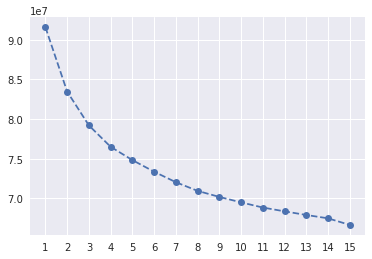

In [141]:
# Investigating the change in within-cluster distance across number of clusters.

plt.plot(centers, scores, linestyle='--', marker='o')
plt.xticks(centers)

In [142]:
for i in range(1,16):
    print("K = {} has a score of {}.".format(i,scores[i-1]))

K = 1 has a score of 91575276.15410703.
K = 2 has a score of 83459110.31254362.
K = 3 has a score of 79196474.98669957.
K = 4 has a score of 76496167.53247747.
K = 5 has a score of 74822176.6637258.
K = 6 has a score of 73355893.75603206.
K = 7 has a score of 72032658.47819372.
K = 8 has a score of 70939446.62230337.
K = 9 has a score of 70177250.3066558.
K = 10 has a score of 69488675.6268825.
K = 11 has a score of 68838551.90076953.
K = 12 has a score of 68356728.62963656.
K = 13 has a score of 67898468.54390158.
K = 14 has a score of 67477797.31105402.
K = 15 has a score of 66646292.89376271.


In [144]:
#re-fitting the model with 7 clusters and obtaining clusters for general population
kmeans7 = KMeans(n_clusters=7)
org_cluster = kmeans7.fit_predict(dataset_lessthan_pca)

### Discussion 3.1: Apply Clustering to General Population

As there is no evident sharp elbow curve, I chose 7 as appropriate number of clusters because there is a minute difference in score after k=7

### Step 3.2: Apply All Steps to the Customer Data

In [146]:
# Loading in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [147]:
customers.shape

(191652, 85)

In [148]:
customers.isnull().sum().sum()

2252274

In [149]:
clean_customers = clean_data(customers)

In [150]:
clean_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,1,0,0,0,0,1.0,2.0,3.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,0.0,4.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,1.0,2.0,3.0,4.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1.0,2.0,2.0,3.0


In [151]:
clean_customers.shape

(128989, 121)

In [152]:
dataset_lessthan.shape 

(798044, 121)

### This shows that the clean_customers and the cleaned original dataset have same number of columns

In [153]:
clean_customers.isnull().sum().sum()

27911

In [154]:
#Applying already created Imputer object

clean_customers = imputer.transform(clean_customers)
clean_customers = pd.DataFrame(clean_customers)
clean_customers.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0
2,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0
3,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0
4,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0


In [155]:
clean_customers.isnull().sum().sum()

0

In [156]:
#Applying already created StandardScaler object

clean_customers = scaler.transform(clean_customers)
clean_customers = pd.DataFrame(clean_customers)
clean_customers.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1.184892,-1.043937,1.409060,-1.155509,1.138164,-1.249983,-0.470389,-0.791237,1.885331,-1.625589,...,-0.38691,-0.272886,-0.3911,-0.328974,-0.450103,-0.395991,1.875393,-1.629720,-1.550655,0.085850
1,1.184892,0.957912,1.409060,-1.155509,1.138164,-1.249983,0.958673,0.629120,1.885331,-0.269825,...,-0.38691,3.664536,-0.3911,-0.328974,-0.450103,-0.395991,1.875393,-1.629720,-0.179674,0.761980
2,0.201242,-1.043937,-0.042767,-1.155509,0.411880,0.786986,1.673203,-0.791237,-0.530411,1.085940,...,-0.38691,-0.272886,-0.3911,3.039758,-0.450103,-0.395991,-0.553150,-0.232017,0.505816,-1.266409
3,0.201242,-1.043937,1.409060,-1.155509,1.138164,-1.249983,-0.470389,-0.081058,1.885331,1.085940,...,-0.38691,3.664536,-0.3911,-0.328974,-0.450103,-0.395991,1.875393,-1.629720,-0.179674,0.761980
4,1.184892,-1.043937,1.409060,-1.155509,1.138164,-1.249983,-1.184919,-0.791237,1.885331,-0.269825,...,-0.38691,-0.272886,-0.3911,-0.328974,-0.450103,-0.395991,1.875393,-1.629720,-0.865164,0.085850


In [157]:
clean_customers.shape

(128989, 121)

In [158]:
#Applying PCA where n=78

clean_customers = pca_78.transform(clean_customers)
clean_customers = pd.DataFrame(clean_customers)
clean_customers.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-6.536791,1.765364,3.772530,1.857084,-3.074728,2.772129,0.139956,1.593218,-1.033367,-0.464096,...,-0.402518,1.065215,-0.244872,-0.195244,-1.112544,0.550380,0.915797,-1.019081,0.195526,0.151381
1,-2.456686,5.329182,-1.013754,2.105457,-2.497535,-1.139542,-1.173937,-0.326349,-1.152230,1.120185,...,0.333623,-0.813102,0.283323,0.119682,-0.088309,0.985681,-0.160691,-0.980334,1.076064,-0.389440
2,0.883283,-1.179807,1.357241,0.986060,3.150104,1.420241,0.877564,-1.754137,-0.263433,-0.704995,...,-0.844025,0.361089,1.398394,-0.026282,-0.222677,-0.069196,0.486027,0.453126,0.678688,0.412712
3,-2.782144,1.088388,3.075558,3.000268,-2.031221,0.710663,1.650365,-1.428398,0.176991,-1.977877,...,0.742790,-1.150426,-0.285164,0.571156,1.072811,-0.617789,-0.341794,0.389803,-0.817085,-0.626884
4,-6.667814,0.555313,3.053366,1.004904,-2.216785,2.178375,-0.123304,0.578301,-0.237186,1.683392,...,0.140995,-0.022025,-0.642421,0.410590,-0.726163,0.108921,0.576230,-0.545747,0.734905,-0.061516


In [163]:
#Applying KMeans on Customer dataset

customer_cluster = kmeans7.predict(clean_customers)

In [164]:
#Finding number of deleted rows from customers

null_values_in_row_2 = customers.isnull().sum(axis=1).sort_values(ascending=False)
customer_rows_deleted = customers[customers.index.isin(null_values_in_row_2[null_values_in_row_2 > 27].index)]
customer_rows_deleted.shape

(49964, 85)

In [165]:
null_values_in_row_2.value_counts().sort_values(ascending=False)

53    40964
2     40402
3     35055
1     18738
4     17221
5      8298
49     5621
6      3823
11     2410
8      2272
9      2175
7      2161
10     1959
12     1837
13     1346
37     1022
36      885
14      698
15      557
38      498
16      481
18      472
17      396
19      349
0       328
35      278
20      200
40      188
39      176
22      163
21      150
41      118
23       96
24       33
26       29
51       23
25       22
50       21
46       20
44       19
47       19
42       18
27       17
48       16
34       16
28       14
43       12
45       11
30        9
29        6
31        4
33        4
32        1
52        1
dtype: int64

In [166]:
#Saving CSV

clean_customers.to_csv('clean_customers.csv',sep=';',encoding='utf-8',index=False)

### Step 3.3: Compare Customer Data to Demographics Data

In [167]:
org_cluster.size

798044

In [168]:
# Comparing the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#Distribution of clusters for general population dataset
org_cluster = pd.Series(org_cluster)
population_clusters = org_cluster.value_counts().sort_index()
population_clusters = pd.Series(population_clusters)
population_clusters

0    104906
1    140005
2    116262
3    132724
4    116495
5    103605
6     84047
dtype: int64

In [169]:
population_clusters.sum() #checking size of population cluster with original cluster

798044

In [172]:
customer_cluster.size

128989

In [173]:
#Distribution of clusters for customer dataset

customer_cluster = pd.Series(customer_cluster)
customer_clusters = customer_cluster.value_counts().sort_index()
customer_clusters = pd.Series(customer_clusters)
customer_clusters

0     2341
1    31705
2    16919
3     1651
4    14876
5    57776
6     3721
dtype: int64

In [174]:
customer_clusters.sum() #checking size of customer cluster with original customer cluster

128989

In [175]:
#Combining both the clusters:

df = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
df.columns = ['cluster_index','population','customer']

In [176]:
df

,cluster_index,population,customer
0,0,104906,2341
1,1,140005,31705
2,2,116262,16919
3,3,132724,1651
4,4,116495,14876
5,5,103605,57776
6,6,84047,3721


Text(0.5,1,'Customer Clusters')

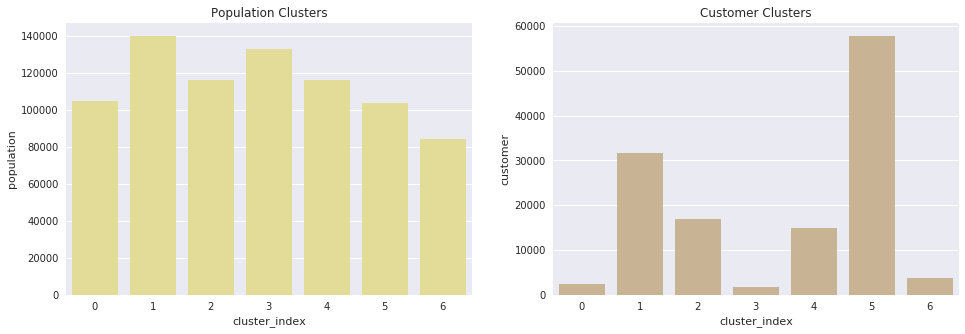

In [177]:
# Comparing both the Clusters

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='cluster_index',y='population', data=df, color = 'khaki')
plt.title("Population Clusters")

ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='cluster_index',y='customer',data=df, color = 'tan')
plt.title("Customer Clusters")

In [178]:
#Finding the proportion of people who belongs to that cluster

df['percent_population'] = (df['population']/df['population'].sum()*100).round(3)
df['percent_customer'] = (df['customer']/df['customer'].sum()*100).round(3)
df['difference'] = df['percent_population'] - df['percent_customer']
df

,cluster_index,population,customer,percent_population,percent_customer,difference
0,0,104906,2341,13.145,1.815,11.330
1,1,140005,31705,17.544,24.580,-7.036
2,2,116262,16919,14.568,13.117,1.451
3,3,132724,1651,16.631,1.280,15.351
4,4,116495,14876,14.598,11.533,3.065
5,5,103605,57776,12.982,44.791,-31.809
6,6,84047,3721,10.532,2.885,7.647


In [179]:
# Deleted rows from population dataset

population_rows_deleted = dataset_greaterthan.shape[0]
population_rows_deleted

93177

In [180]:
# Deleted rows from customer dataset

customer_rows_deleted = customer_rows_deleted.shape[0]
customer_rows_deleted

49964

In [181]:
#Creating new DataFrame to add the number of deleted rows from both the datasets

new_df = pd.DataFrame(df)

In [182]:
new_df.loc[7] = ['7', population_rows_deleted, customer_rows_deleted,0,0,0]

In [183]:
new_df 

,cluster_index,population,customer,percent_population,percent_customer,difference
0,0,104906,2341,13.145,1.815,11.330
1,1,140005,31705,17.544,24.580,-7.036
2,2,116262,16919,14.568,13.117,1.451
3,3,132724,1651,16.631,1.280,15.351
4,4,116495,14876,14.598,11.533,3.065
5,5,103605,57776,12.982,44.791,-31.809
6,6,84047,3721,10.532,2.885,7.647
7,7,93177,49964,0.000,0.000,0.000


In [184]:
# Calculating new proportions

new_df['percent_population'] = (new_df['population']/new_df['population'].sum()*100).round(3)
new_df['percent_customer'] = (new_df['customer']/new_df['customer'].sum()*100).round(3)
new_df['difference'] = new_df['percent_population'] - new_df['percent_customer']
new_df

,cluster_index,population,customer,percent_population,percent_customer,difference
0,0,104906,2341,11.771,1.308,10.463
1,1,140005,31705,15.709,17.717,-2.008
2,2,116262,16919,13.045,9.454,3.591
3,3,132724,1651,14.892,0.923,13.969
4,4,116495,14876,13.071,8.313,4.758
5,5,103605,57776,11.625,32.286,-20.661
6,6,84047,3721,9.431,2.079,7.352
7,7,93177,49964,10.455,27.920,-17.465


Text(0.5,1,'Customer Clusters % with deleted row')

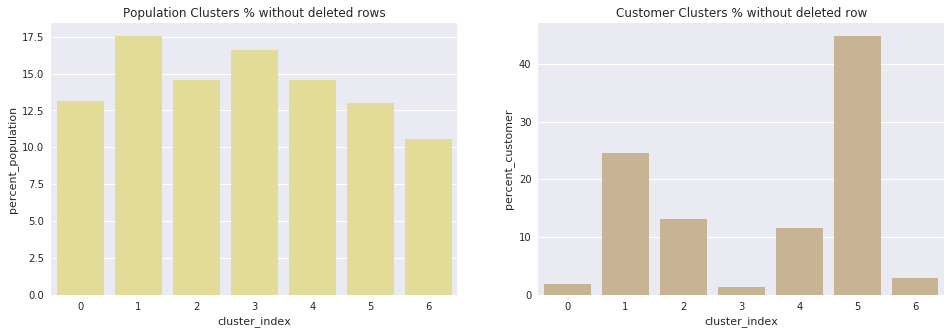

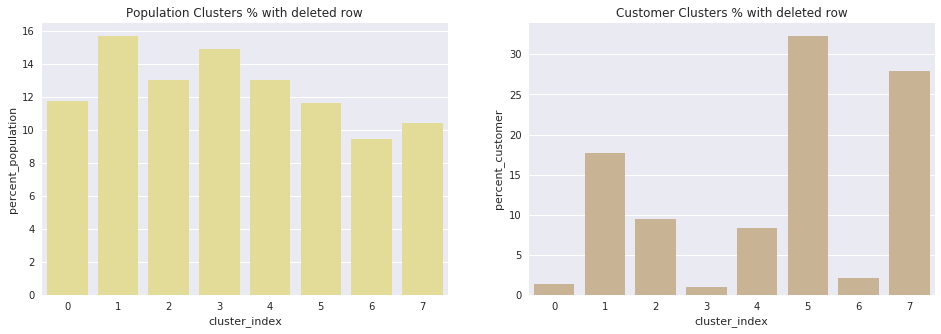

In [185]:
# Plotting proportions with deleted rows and undeleted rows 

fig1 = plt.figure(figsize=(16,5))

ax1 = fig1.add_subplot(121)
ax1 = sns.barplot(x='cluster_index',y='percent_population', data=df, color = 'khaki')
plt.title("Population Clusters % without deleted rows")

ax2 = fig1.add_subplot(122)
ax2 = sns.barplot(x='cluster_index',y='percent_customer',data=df, color = 'tan')
plt.title("Customer Clusters % without deleted row")

fig2 = plt.figure(figsize=(16,5))
ax3 = fig2.add_subplot(121)
ax3 = sns.barplot(x='cluster_index',y='percent_population', data=new_df, color = 'khaki')
plt.title("Population Clusters % with deleted row")

ax4 = fig2.add_subplot(122)
ax4 = sns.barplot(x='cluster_index',y='percent_customer',data=new_df, color = 'tan')
plt.title("Customer Clusters % with deleted row")

### Creating new dataframe for combining proportions of customers and population to plot together

In [186]:
population = pd.DataFrame(new_df['percent_population'])

In [187]:
population['origin'] = 'population'

In [188]:
population['label'] = [0,1,2,3,4,5,6,7]

In [189]:
population.columns = [ 'percentage', 'origin', 'label']

In [190]:
population

,percentage,origin,label
0,11.771,population,0
1,15.709,population,1
2,13.045,population,2
3,14.892,population,3
4,13.071,population,4
5,11.625,population,5
6,9.431,population,6
7,10.455,population,7


In [191]:
customer = pd.DataFrame(new_df['percent_customer'])

In [192]:
customer['origin'] = 'customer'

In [193]:
customer['label'] = [0,1,2,3,4,5,6,7]

In [194]:
customer.columns = [ 'percentage', 'origin', 'label']

In [195]:
customer

,percentage,origin,label
0,1.308,customer,0
1,17.717,customer,1
2,9.454,customer,2
3,0.923,customer,3
4,8.313,customer,4
5,32.286,customer,5
6,2.079,customer,6
7,27.920,customer,7


In [196]:
combined_df = pd.concat([population,customer])
combined_df

,percentage,origin,label
0,11.771,population,0
1,15.709,population,1
2,13.045,population,2
3,14.892,population,3
4,13.071,population,4
5,11.625,population,5
6,9.431,population,6
7,10.455,population,7
0,1.308,customer,0
1,17.717,customer,1


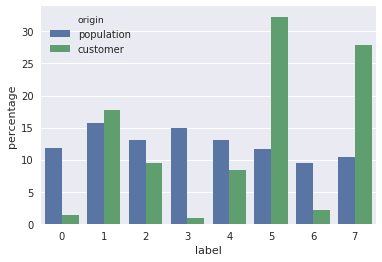

In [197]:
sns.barplot(x='label', y='percentage', hue='origin', data=combined_df);

In [1]:
#cluster 5 has people over represented in customer data

## Examining Cluster 5

In [199]:
cluster_5 = kmeans7.cluster_centers_[5]
cluster_5 = pd.Series(cluster_5).round(3)
cluster_5.sort_values(ascending=False)

3     2.745
1     0.608
2     0.535
9     0.436
17    0.349
23    0.216
32    0.140
63    0.094
54    0.093
20    0.083
76    0.081
34    0.077
57    0.074
26    0.073
58    0.069
43    0.069
47    0.067
15    0.066
18    0.064
30    0.059
12    0.054
59    0.053
74    0.050
31    0.049
37    0.043
24    0.042
38    0.034
70    0.032
53    0.025
69    0.024
      ...  
68   -0.049
22   -0.060
52   -0.061
39   -0.066
48   -0.066
50   -0.077
33   -0.078
73   -0.080
28   -0.087
8    -0.090
56   -0.091
61   -0.092
44   -0.093
64   -0.108
62   -0.111
29   -0.111
42   -0.119
21   -0.129
16   -0.167
51   -0.168
27   -0.178
25   -0.178
5    -0.343
13   -0.378
6    -0.388
11   -0.500
10   -0.536
14   -0.575
4    -0.761
0    -4.357
Length: 78, dtype: float64

In [201]:
cluster_5_original = scaler.inverse_transform(pca_78.inverse_transform(cluster_5))
cluster_5_original = pd.Series(cluster_5_original).round(3)
cluster_5_original.index = column_name
cluster_5_original

ALTERSKATEGORIE_GROB         3.374
ANREDE_KZ                    1.492
FINANZ_MINIMALIST            4.572
FINANZ_SPARER                1.595
FINANZ_VORSORGER             4.258
FINANZ_ANLEGER               1.778
FINANZ_UNAUFFAELLIGER        2.084
FINANZ_HAUSBAUER             2.058
GREEN_AVANTGARDE             0.987
HEALTH_TYP                   2.079
LP_FAMILIE_FEIN              5.537
RETOURTYP_BK_S               3.764
SEMIO_SOZ                    3.974
SEMIO_FAM                    3.403
SEMIO_REL                    2.965
SEMIO_MAT                    3.137
SEMIO_VERT                   4.712
SEMIO_LUST                   5.279
SEMIO_ERL                    5.156
SEMIO_KULT                   3.503
SEMIO_RAT                    3.131
SEMIO_KRIT                   4.492
SEMIO_DOM                    4.700
SEMIO_KAEM                   4.191
SEMIO_PFLICHT                3.151
SEMIO_TRADV                  3.015
SOHO_KZ                      0.009
VERS_TYP                     1.502
ANZ_PERSONEN        

In [202]:
weights(3)

Principal Component: 3


,Weights
SEMIO_VERT,0.3253
SEMIO_FAM,0.2593
SEMIO_SOZ,0.2585
SEMIO_KULT,0.2486
FINANZTYP_5,0.1377
FINANZ_MINIMALIST,0.1307
SHOPPER_TYP_0.0,0.1266
ZABEOTYP_1,0.1076
SEMIO_REL,0.1028
RETOURTYP_BK_S,0.0856


In [203]:
weights(2)

Principal Component: 2


,Weights
ALTERSKATEGORIE_GROB,0.2269
FINANZ_VORSORGER,0.2122
ZABEOTYP_3,0.2045
SEMIO_ERL,0.1862
SEMIO_LUST,0.1604
RETOURTYP_BK_S,0.1538
W_KEIT_KIND_HH,0.1314
FINANZ_HAUSBAUER,0.1132
CJT_GESAMTTYP_2.0,0.1066
FINANZTYP_5,0.0951


In [204]:
weights(1)

Principal Component: 1


,Weights
LP_STATUS_GROB_1.0,0.2022
HH_EINKOMMEN_SCORE,0.1915
PLZ8_ANTG3,0.1902
CAMEO_INTL_2015_WEALTH,0.1884
PLZ8_ANTG4,0.1838
ORTSGR_KLS9,0.1621
EWDICHTE,0.1608
FINANZ_HAUSBAUER,0.1480
FINANZ_SPARER,0.1433
FINANZTYP_1,0.1326


In [ ]:
#cluster 4 have uderpresented people in the customer data compared to the general population

## Examining Cluster 3

In [205]:
cluster_3 = kmeans7.cluster_centers_[3]
cluster_3 = pd.Series(cluster_3).round(3)
cluster_3.sort_values(ascending=False)

0     5.267
9     0.370
16    0.239
7     0.235
3     0.211
12    0.145
55    0.127
10    0.125
23    0.120
56    0.087
26    0.067
34    0.065
43    0.061
45    0.059
30    0.057
59    0.053
19    0.051
50    0.044
54    0.044
24    0.043
53    0.034
46    0.033
58    0.032
5     0.030
28    0.027
31    0.025
20    0.023
49    0.022
72    0.016
71    0.015
      ...  
48   -0.029
57   -0.029
33   -0.035
35   -0.039
44   -0.039
32   -0.039
70   -0.039
4    -0.047
15   -0.052
52   -0.056
22   -0.061
27   -0.062
14   -0.063
61   -0.070
42   -0.076
41   -0.081
65   -0.083
67   -0.084
29   -0.088
40   -0.100
51   -0.104
13   -0.123
64   -0.167
18   -0.175
21   -0.191
8    -0.220
6    -0.240
2    -0.375
11   -0.412
1    -1.642
Length: 78, dtype: float64

In [206]:
cluster_3_original = scaler.inverse_transform(pca_78.inverse_transform(cluster_3))
cluster_3_original = pd.Series(cluster_3_original).round(3)
cluster_3_original.index = column_name
cluster_3_original

ALTERSKATEGORIE_GROB         1.830
ANREDE_KZ                    1.590
FINANZ_MINIMALIST            1.341
FINANZ_SPARER                4.471
FINANZ_VORSORGER             2.087
FINANZ_ANLEGER               3.996
FINANZ_UNAUFFAELLIGER        3.815
FINANZ_HAUSBAUER             4.018
GREEN_AVANTGARDE             0.050
HEALTH_TYP                   2.279
LP_FAMILIE_FEIN              2.961
RETOURTYP_BK_S               2.688
SEMIO_SOZ                    4.522
SEMIO_FAM                    5.045
SEMIO_REL                    5.736
SEMIO_MAT                    4.826
SEMIO_VERT                   3.693
SEMIO_LUST                   3.277
SEMIO_ERL                    3.591
SEMIO_KULT                   5.167
SEMIO_RAT                    5.224
SEMIO_KRIT                   4.495
SEMIO_DOM                    4.812
SEMIO_KAEM                   4.712
SEMIO_PFLICHT                5.930
SEMIO_TRADV                  5.133
SOHO_KZ                      0.008
VERS_TYP                     1.497
ANZ_PERSONEN        

In [207]:
weights(0)

Principal Component: 0


,Weights
LP_STATUS_GROB_1.0,0.2022
HH_EINKOMMEN_SCORE,0.1915
PLZ8_ANTG3,0.1902
CAMEO_INTL_2015_WEALTH,0.1884
PLZ8_ANTG4,0.1838
ORTSGR_KLS9,0.1621
EWDICHTE,0.1608
FINANZ_HAUSBAUER,0.1480
FINANZ_SPARER,0.1433
FINANZTYP_1,0.1326


In [208]:
weights(9)

Principal Component: 9


,Weights
ZABEOTYP_6,0.2849
FINANZTYP_6,0.2389
SEMIO_MAT,0.2224
SEMIO_RAT,0.2167
SEMIO_TRADV,0.2150
NATIONALITAET_KZ_2.0,0.1655
SEMIO_PFLICHT,0.1528
WOHNDAUER_2008,0.1508
SEMIO_REL,0.1311
NATIONALITAET_KZ_3.0,0.1278


In [209]:
weights(16)

Principal Component: 16


,Weights
ANZ_TITEL,0.2874
LP_STATUS_GROB_3.0,0.2837
ANZ_HH_TITEL,0.2395
ZABEOTYP_4,0.2230
REGIOTYP,0.1754
CAMEO_DEUG_2015_7,0.1563
KKK,0.1519
CAMEO_INTL_2015_WEALTH,0.1402
FINANZTYP_4,0.1399
KBA05_GBZ,0.1342


### Discussion 3.3: Compare Customer Data to Demographics Data

The combined barplot shows the **most relevant customers for the company are in cluster 5 followed by cluster 1 and least relevant in cluster 3 followed by 0 and 6**. Most and least relevant customers can also be inferred from the difference in proportion of both the plots. The least the difference, the higher is relevance and more the difference, less is the relevance.

I started my comparision by considering the data with only <=5 null values in both the dataset. The comparision showed the most relevant customers for the company are in cluster 5 and least relevant in cluster 0. The deleted rows can affect the results, so I created a new dataframe by adding the number of deleted rows and calculated proportions.

As the new prediction showed that cluster 5 has people over represented in customer data, I examined it further to find the category of people falling in that cluster. The analysis show that **principal components 3, 2, and 1 have highest impact on Cluster 5**. So analysed the principal components to find the most relevant customers

## Cluster 5

### Principal Component: 3
**Most Prominent-** SEMIO_VERT:	0.3247 (Personality typology, dreamful) | SEMIO_SOZ:	0.2580 (Personality typology, socially-minded) | SEMIO_FAM:	0.2579 (Personality typology, family-minded) | SEMIO_KULT:	0.2427 (Personality typology, cultural-minded) | FINANZTYP_5:	0.1417 (Most descriptive financial type for individual, investor (ANLEGER))

**Least Prominent-** ANREDE_KZ:	-0.3476 (Gender) | SEMIO_KAEM	-0.3183 (Personality typology, combative attitude) |  SEMIO_DOM	-0.2880 (Personality typology, dominant-minded) | SEMIO_KRIT	-0.2621 (Personality typology, critical-minded) | SEMIO_ERL	-0.1972 (Personality typology, event-oriented)
                     
**The above most and least prominent features shows the principal component 3 is related to personality of an individual. Principal component 3 is positively correlated to characteristics like kind or emphathetic and negatively correlated to characteristics like mean or aggressive.**

### Principal Component: 2
**Most Prominent-** ALTERSKATEGORIE_GROB:	0.2165 (Estimated age based on given name analysis) | FINANZ_VORSORGER:	0.2070 (Financial typology, be prepared) | ZABEOTYP_3:	0.2015 (Energy consumption typology, fair supplied) |  SEMIO_ERL:	0.1830 (Personality typology, event-oriented) | RETOURTYP_BK_S:	0.1561 (Return type)
                    
**Least Prominent-** SEMIO_REL:	-0.2116 (Personality typology, religious) | FINANZ_SPARER	-0.2111 (Financial typology, money-saver) | FINANZ_UNAUFFAELLIGER	-0.2081 (Financial typology, inconspicuous) | SEMIO_TRADV:	-0.2011 (Personality typology, tradional-minded) | SEMIO_PFLICHT	-0.1980 (Personality typology, dutiful)

**The above most and least prominent features shows the principal component 2 is related to people between 30-60 years of age. Principal component 2 is positively correlated to person's financial stability and shopping habits and negatively correlated to their self principles and religious beliefs.**


### Principal Component: 1
**Most Prominent-** LP_STATUS_GROB_1.0: 	0.1963 (low-income earners) | HH_EINKOMMEN_SCORE:	0.1884 (Estimated household net income) | PLZ8_ANTG3:	0.1827 (Number of 6-10 family houses in the PLZ8 region) 

**Least Prominent-** MOBI_REGIO: 	-0.2067 (Movement patterns) | FINANZ_MINIMALIST:	-0.2035 (Financial typology, low financial interest) | KBA05_ANTG1:	-0.1943 (Number of 1-2 family houses in the microcell)

**The above most and least prominent features shows the principal component 1 is related to region. Principal component 1 has positive correlation with high income and more number of houses in that region and have negative correlation with low income and low number of houses**

As the new prediction also showed that cluster 4 have most people under represented in customer data, I examined it further to find the category of people falling in that cluster. The analysis show that **principal components 23, 5, and 17 have highest impact on Cluster 4**. 


## Cluster 3

### Principal Component: 0
**Most Prominent-** LP_STATUS_GROB_1.0	0.2022 (Social status, rough scaleindependents, low-income earners (maps to 1-2 in fine scale)) | HH_EINKOMMEN_SCORE	0.1915 (Estimated household net income) | PLZ8_ANTG3	0.1902  (Number of 6-10 family houses in the PLZ8 region) | CAMEO_INTL_2015_WEALTH	0.1884 (Wealth) | PLZ8_ANTG4	0.1838 (Number of 10+ family houses in the PLZ8 region)

**Least Prominent-** KBA05_GBZ	-0.1880 (Number of buildings in the microcell) | PLZ8_ANTG1	-0.1903 (Number of 1-2 family houses in the PLZ8 region, lower share of 1-2 family homes) | KBA05_ANTG1	-0.1984 (Number of 1-2 family houses in the microcell, lower share of 1-2 family homes) | FINANZ_MINIMALIST	-0.2097 ( (Financial typology, low financial interest)) | MOBI_REGIO	-0.2116 ((Movement patterns)

**The above most and least prominent features shows the principal component 0 is related to a city with low earners. Principal component 0 is positively correlated to number of houses and their income and negatively correlated to number of small family home.**

### Principal Component: 9
**Most Prominent-** ZABEOTYP_6	0.2849 (Energy consumption typology, indifferent) | FINANZTYP_6	0.2389 (Most descriptive financial type for individual, inconspicuous (UNAUFFAELLIGER)) | SEMIO_MAT	0.2224 (materialistic) | SEMIO_RAT	0.2167 (rational) | SEMIO_TRADV	0.2150 (tradional-minded)

**Least Prominent-** KKK	-0.1758 (Purchasing power in region) | FINANZTYP_3	-0.1824 (Most descriptive financial type for individual, home ownership (HAUSBAUER)) | REGIOTYP	-0.1884 (Neighborhood typology) | NATIONALITAET_KZ_1.0	-0.2140 (Nationality based on given name analysis, German-sounding) | FINANZ_UNAUFFAELLIGER	-0.2266 (Financial typology, inconspicuous)

**The above most and least prominent features shows the principal component 9 is related to financial status of an individual. Principal component 9 is positively correlated to financial capability and negatively correlated to the nationality of a person.**

### Principal Component: 16
**Most Prominent-** ANZ_TITEL	0.2874 (Number of professional academic title holders in household) | LP_STATUS_GROB_3.0	0.2837 (Social status, rough scale, independents (maps to 6-7 in fine scale)) | ANZ_HH_TITEL	0.2395 (Number of professional academic title holders in building) | ZABEOTYP_4	0.2230 (Energy consumption typology, price driven) | REGIOTYP	0.1754 (Neighborhood typology)


**Least Prominent-** CAMEO_INTL_2015_LIFESTAGE	-0.1537 (German CAMEO: Wealth / Life Stage Typology, mapped to international code) | VERS_TYP	-0.1600 (Insurance typology) | HEALTH_TYP	-0.1714 (Health typology) | 
CJT_GESAMTTYP_3.0	-0.1878 (Customer-Journey-Typology: preferred information and buying channels for consumer, advertisinginterested Store-shopper) | KBA05_ANTG3	-0.1977 (Number of 6-10 family houses in the microcell)

**The above most and least prominent features shows the principal component 16 is related to educated people in that region. Principal component 16 is positively correlated to people who have higher qualification and negatively correlated to large families in that region.**


## Above analysis shows that the company can target people of different nationalities who earns average or below average income and are >30 years of age and are dutiful and family-oriented.